In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist 
from skimage.transform import resize
from keras.utils import to_categorical
import pandas as pd

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

x_train = X_train.reshape(X_train.shape[0], 28*28)
x_train = x_train/float(255)

X_test = X_test.reshape(-1, 28*28)
X_test = X_test/float(255)
Y_test = to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000, 10)


In [3]:
class digit:
    def __init__(self, X, Y, m1, m2, batches, gamma, epochs):
        '''
        X       : Training input
        Y       : Training output
        gamma   : Learning rate
        epochs  : Training iterations
        m1      : Number of nodes in layer 1
        m2      : Number of nodes in layer 2

        self.N  : Number of datapoints
        self.L  : Number of nodes in input layer
        self.K  : Number of nodes in output layer
        '''
        
        self.X = X
        self.Y = to_categorical(Y)
        self.gamma = gamma
        self.epochs = epochs
        self.m1 = m1
        self.m2 = m2
        self.batches = batches
        
        self.N, self.L = X.shape
        self.K = self.Y.shape[1]
        
        print("Y shape ", self.Y.shape)
        
    def sigmoid(self, x):
        return (1/(1+np.exp(-1.0*x)))

    def sigmoid_prime(self, x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def mini_batch(self, x, y):
        #FeedForward
        z1 = np.matmul(x, self.W1) + self.b1.reshape(1,-1)
        a1 = self.sigmoid(z1)
        z2 = np.matmul(a1, self.W2) + self.b2.reshape(1,-1)
        a2 = self.sigmoid(z2)
        z3 = np.matmul(a2, self.W3) + self.b3.reshape(1,-1)
        a = self.sigmoid(z3)
        
        #BackPropogation
        deltaL = (a - y) * self.sigmoid_prime(z3)
        delta2 = np.matmul(deltaL, self.W3.T) * self.sigmoid_prime(z2)
        delta1 = np.matmul(delta2, self.W2.T) * self.sigmoid_prime(z1)
        
        n = x.shape[0]
        
        self.W3 = self.W3 - (self.gamma*np.matmul(a2.T, deltaL))/float(n)
        self.b3 = self.b3 - (self.gamma*np.sum(deltaL, axis = 0).reshape(1,-1))/float(n)
        self.W2 = self.W2 - (self.gamma*np.matmul(a1.T, delta2))/float(n)
        self.b2 = self.b2 - (self.gamma*np.sum(delta2, axis = 0).reshape(1,-1))/float(n)
        self.W1 = self.W1 - (self.gamma*np.matmul(x.T, delta1))/float(n)
        self.b1 = self.b1 - (self.gamma*np.sum(delta1, axis = 0).reshape(1,-1))/float(n)
        
        
    def train(self):
        #Initialization
        self.W1 = np.random.normal(scale = 1.0/self.m1, size = (self.L, self.m1))
        self.b1 = np.random.normal(scale = 1.0/self.m1, size = (1,self.m1))
        self.W2 = np.random.normal(scale = 1.0/self.m2, size = (self.m1, self.m2))
        self.b2 = np.random.normal(scale = 1.0/self.m2, size = (1,self.m2))
        self.W3 = np.random.normal(scale = 1.0/self.K, size = (self.m2, self.K))
        self.b3 = np.random.normal(scale = 1.0/self.K, size = (1,self.K))
        
        dataset = np.append(self.X, self.Y, axis = 1)
        #print("In train", self.X.shape, self.Y.shape, dataset.shape, self.gamma)
        
        training_error = []
        for epoch in range(self.epochs):
            np.random.shuffle(dataset)
            
            #Making batches
            jump = int(self.N/self.batches)
            for i in range(0, self.N, jump):
                xtr = dataset[i:i+jump, :self.L]
                ytr = dataset[i:i+jump, self.L:]
                self.mini_batch(xtr, ytr)
            
            #self.mini_batch(self.X, self.Y)
            
            e = self.error()
            training_error.append((epoch, e))
            if(epoch<5 or (epoch%100)==0):
                print("Epoch = ", epoch, " Error = ", e)
            
        print("Training error = ", self.error())
        return training_error
        
    def predict(self, x):
        #FeedForward
        z1 = np.matmul(x, self.W1) + self.b1.reshape(1,-1)
        a1 = self.sigmoid(z1)
        z2 = np.matmul(a1, self.W2) + self.b2.reshape(1,-1)
        a2 = self.sigmoid(z2)
        z3 = np.matmul(a2, self.W3) + self.b3.reshape(1,-1)
        a = self.sigmoid(z3)
        
        p = np.argmax(a, axis = 1)
        
        return a, p
    
    def error(self):
        y_cap, p = self.predict(self.X)
        error = np.sqrt(np.sum((y_cap-self.Y)**2, dtype = np.float64)/float(self.N))

        return error

    def test(self, x, y):
        n = y.shape[0]
        y_cap, p = self.predict(x)
        error = np.sqrt(np.sum((y_cap-y)**2, dtype = np.float64)/float(n))
        
        return error

    def acc(self, x, y):
        n = y.shape[0]
        y_cap, p = self.predict(x)
        d = p - y
        a = np.count_nonzero(d)

        #print("Total Predictions: ", n, "\nCorrect Predictions: ", (n-a), "Incorrect Prediction: ", a)

        return ((n-a)/n)

# **Training**

In [4]:
m1 = 256
m2 = 16
batches = 30
gamma = 0.8
epochs = 1200

xt = x_train[:, :]
yt = y_train[:]

nn = digit(xt, yt, m1, m2, batches, gamma, epochs)
tr_set = nn.train()

print("Testing Error = ", nn.test(X_test, Y_test))

Y shape  (60000, 10)
Epoch =  0  Error =  0.9485048859473171
Epoch =  1  Error =  0.9483870719739784
Epoch =  2  Error =  0.9483184837500079
Epoch =  3  Error =  0.9482511175718729
Epoch =  4  Error =  0.9481676300064241
Epoch =  100  Error =  0.4517835450435762
Epoch =  200  Error =  0.35431662593031443
Epoch =  300  Error =  0.3089241061371058
Epoch =  400  Error =  0.2750988665460167
Epoch =  500  Error =  0.2482572238886742
Epoch =  600  Error =  0.22608725862638246
Epoch =  700  Error =  0.20759562174256885
Epoch =  800  Error =  0.19202763701855688
Epoch =  900  Error =  0.1789400878185304
Epoch =  1000  Error =  0.16766440158805573
Epoch =  1100  Error =  0.15771630428915248
Training error =  0.14868029120441806
Testing Error =  0.19801123854786712


In [5]:
print("Accuracy = ", nn.acc(X_test, y_test))

Accuracy =  0.9771


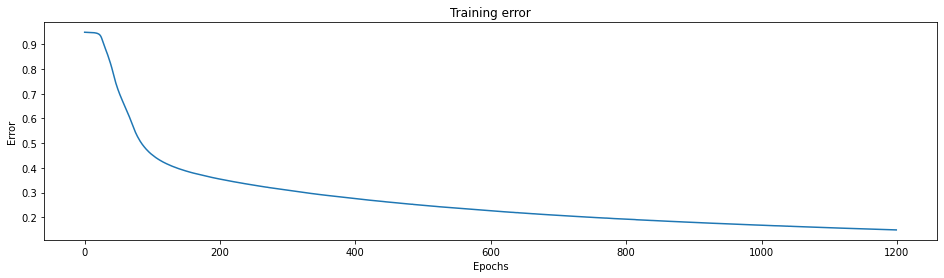

In [6]:
x1 = [i for i, j in tr_set]
y1 = [j for i, j in tr_set]
plt.figure(figsize=((16,4)))
plt.plot(x1, y1, label = 'train')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Training error")

plt.show()

# **Prediction**

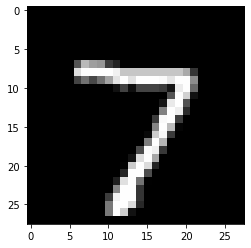

Predicted Value =  7


In [7]:
x = X_test[0]
y, p = nn.predict(x)
x = x.reshape(28,28)
plt.imshow(x, cmap = 'gray')
plt.show()

print("Predicted Value = ", p[0])

In [9]:
#Storing

df = pd.DataFrame(nn.W1)
df.to_csv('W1.csv', index=False)
df = pd.DataFrame(nn.b1)
df.to_csv('b1.csv', index=False)

df = pd.DataFrame(nn.W2)
df.to_csv('W2.csv', index=False)
df = pd.DataFrame(nn.b2)
df.to_csv('b2.csv', index=False)

df = pd.DataFrame(nn.W3)
df.to_csv('W3.csv', index=False)
df = pd.DataFrame(nn.b3)
df.to_csv('b3.csv', index=False)